_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: *Jannis Ahlert, Julius Grote , Hun Seok Choi*

LLM Disclaimer: *Github Copilot and Chat gpt, used for autompletion and debugging.*

# Coding Lab 2

## Introduction

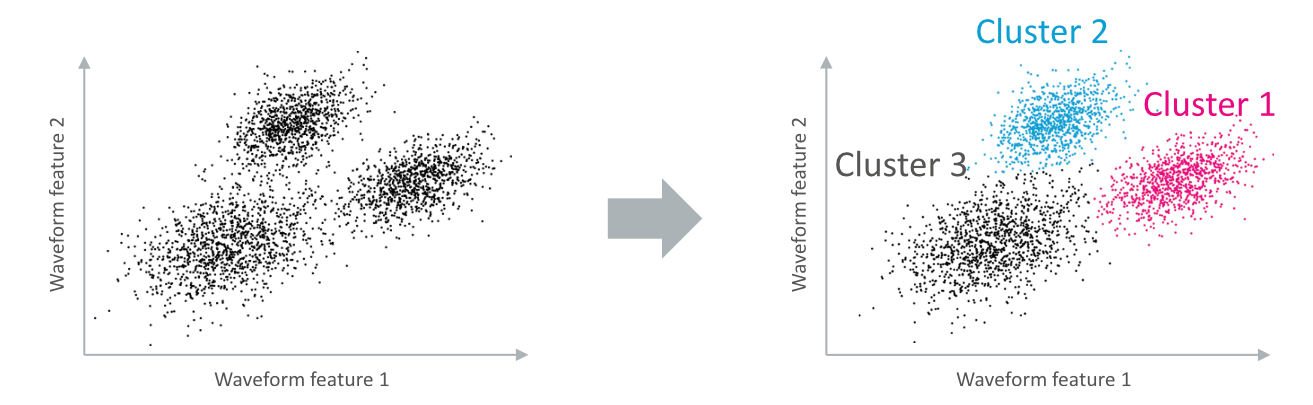

In this coding lab, we continue with the data from the first coding lab and finalize the Spike Sorting pipeline.
In particular, we use the created feature space to identify individual clusters by fitting a Gaussian Mixture Model.
To verify that this model does what we want, we first create a synthetic Toy Dataset and apply the model to that.

- __Data__: Use the saved data `nds_cl_1_*.npy` from Coding Lab 1. Or, if needed, download the data files ```nds_cl_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

In [17]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from __future__ import annotations
from scipy.special import gamma


%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-05-04 21:45:51CEST

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.35.0

sklearn: 1.6.1

sklearn   : 1.6.1
numpy     : 2.2.5
scipy     : 1.15.2
matplotlib: 3.10.1

Watermark: 2.5.0



In [5]:
plt.style.use("../matplotlibtyle.txt")

## Load data

In [51]:
# replace by path to your solutions
b = np.load("../data/nds_cl_1_features.npy")
s = np.load("../data/nds_cl_1_spiketimes_s.npy")
t = np.load("../data/nds_cl_1_spiketimes_t.npy")
w = np.load("../data/nds_cl_1_waveforms.npy")

## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 2 pts*


In [8]:
def sample_data(
    n_samples: int, m: np.ndarray, S: np.ndarray, p: np.ndarray, random_seed: int = 0
) -> tuple[np.ndarray, np.ndarray]:
    """Generate n_samples samples from a Mixture of Gaussian distribution with
    means m, covariances S and priors p.

    Parameters
    ----------

    n_samples: int
        Number of samples

    m: np.ndarray, (n_clusters, n_dims)
        Means

    S: np.ndarray, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.ndarray, (n_clusters, )
        Cluster weights / probablities

    random_seed: int
        Random Seed

    Returns
    -------

    labels: np.array, (n_samples, )
        Grund truth labels.

    x: np.array, (n_samples, n_dims)
        Data points
    """
    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)

    # ------------------------------------------------------
    # draw labeled points from mixture of Gaussians (1 pt)
    # ------------------------------------------------------

    labels = rng.multinomial(1, p, size=n_samples).argmax(axis=1)
    points = np.empty((n_samples, m.shape[1]))
    for i in range(m.shape[0]):
        points[labels == i] = rng.multivariate_normal(
            m[i], S[i], size=(labels == i).sum()
        )

    return (points, labels)

In [9]:
N = 1000  # total number of samples

p = np.array([0.3, 0.5, 0.2])  # percentage of each cluster
m = np.array([[0.0, 0.0], [5.0, 1.0], [0.0, 4.0]])  # means

S1 = np.array([[1.0, 0.0], [0.0, 1.0]])
S2 = np.array([[2.0, 1.0], [1.0, 2.0]])
S3 = np.array([[1.0, -0.5], [-0.5, 1.0]])
S = np.stack([S1, S2, S3])  # cov

# labels, x = sample_data(N, m, S, p)

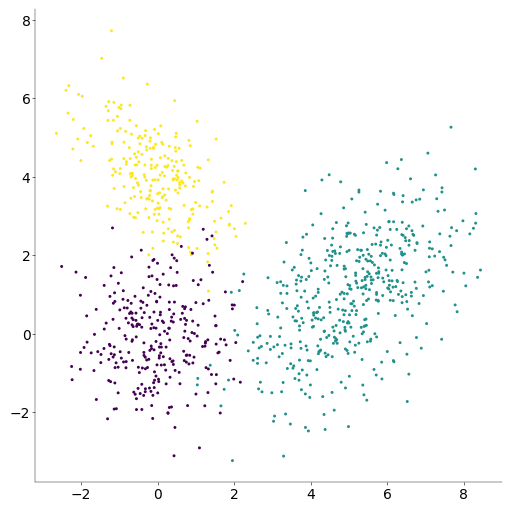

In [10]:
# ----------------------------------------------
# plot points from mixture of Gaussians (1 pt)
# ----------------------------------------------

fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")
points, labels = sample_data(N, m, S, p)
ax.scatter(points[:, 0], points[:, 1], c=labels, s=5, cmap="viridis")

## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `fit_mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.  

*Grading: 6 pts*


In [11]:
def fit_mog(
    x: np.ndarray,
    n_clusters: int,
    n_iters: int = 10,
    random_seed: int = 0,
    init: str = "random",
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Fit Mixture of Gaussian model using EM algo.

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    n_clusters: int
        Number of clusters

    n_iters: int
        Maximal number of iterations.

    random_seed: int
        Random Seed


    Returns
    -------

    labels: np.array, (n_samples)
        Cluster labels

    m: list or np.array, (n_clusters, n_dims)
        Means

    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: list or np.array, (n_clusters, )
        Cluster weights / probablities
    """
    # ensure reproducibility using a random number generator
    rng = np.random.default_rng(random_seed)

    # -----------
    # init (1 pt)
    # -----------

    if init == "random":
        labels = rng.integers(0, n_clusters, size=x.shape[0])

        # perform one m-step to get initial m, S and p
        m = np.empty((n_clusters, x.shape[1]))
        S = np.empty((n_clusters, x.shape[1], x.shape[1]))
        p = np.empty(n_clusters)
        for i in range(n_clusters):
            m[i] = (
                x[labels == i].mean(axis=0)
                if (labels == i).sum() > 0
                else rng.random(x.shape[1])
            )
            S[i] = (
                np.cov(x[labels == i].T)
                if (labels == i).sum() > 1
                else np.eye(x.shape[1])
            )
            p[i] = (labels == i).sum() / x.shape[0]
        # Normalize `p` to ensure it sums to 1
        p /= p.sum()

    elif init == "kmeans":
        # use sklearn KMeans to get initial cluster centers
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed).fit(x)
        m = kmeans.cluster_centers_
        labels = kmeans.labels_
        # compute covariance matrices and cluster weights
        S = np.empty((n_clusters, x.shape[1], x.shape[1]))
        p = np.empty(n_clusters)
        for i in range(n_clusters):
            S[i] = np.cov(x[labels == i].T)
            p[i] = (labels == i).sum() / x.shape[0]

    # -------------------------
    # EM maximisation (3 pts)
    # -------------------------

    for step in range(n_iters):

        # E step
        r = np.empty(
            (x.shape[0], n_clusters)
        )  # x.shape[0] samples, n_clusters clusters
        # r is the posterior probability of each sample belonging to each cluster based on the current m, S and p
        for i in range(n_clusters):
            r[:, i] = p[i] * sp.stats.multivariate_normal.pdf(x, mean=m[i], cov=S[i])
        r /= r.sum(axis=1, keepdims=True)
        assert r.shape == (
            x.shape[0],
            n_clusters,
        ), "r must have shape (n_samples, n_clusters)"
        assert np.allclose(
            r.sum(axis=1), 1
        ), "r must be normalized to 1 for each sample"

        # M step
        # Update `m`, `S` and `p` using the posterior probabilities `r`
        m = np.empty((n_clusters, x.shape[1]))
        S = np.empty((n_clusters, x.shape[1], x.shape[1]))
        p = np.empty(n_clusters)
        for i in range(n_clusters):
            m[i] = (r[:, i] @ x) / r[:, i].sum()
            S[i] = (x - m[i]).T @ (r[:, i][:, np.newaxis] * (x - m[i])) / r[:, i].sum()
            p[i] = r[:, i].sum() / x.shape[0]
        # Normalize `p` to ensure it sums to 1
        p /= p.sum()

        # create labels based on the posterior probabilities
        labels = r.argmax(axis=1)

    return labels, m, S, p

Run Mixture of Gaussian on toy data

Text(0, 0.5, 'x2')

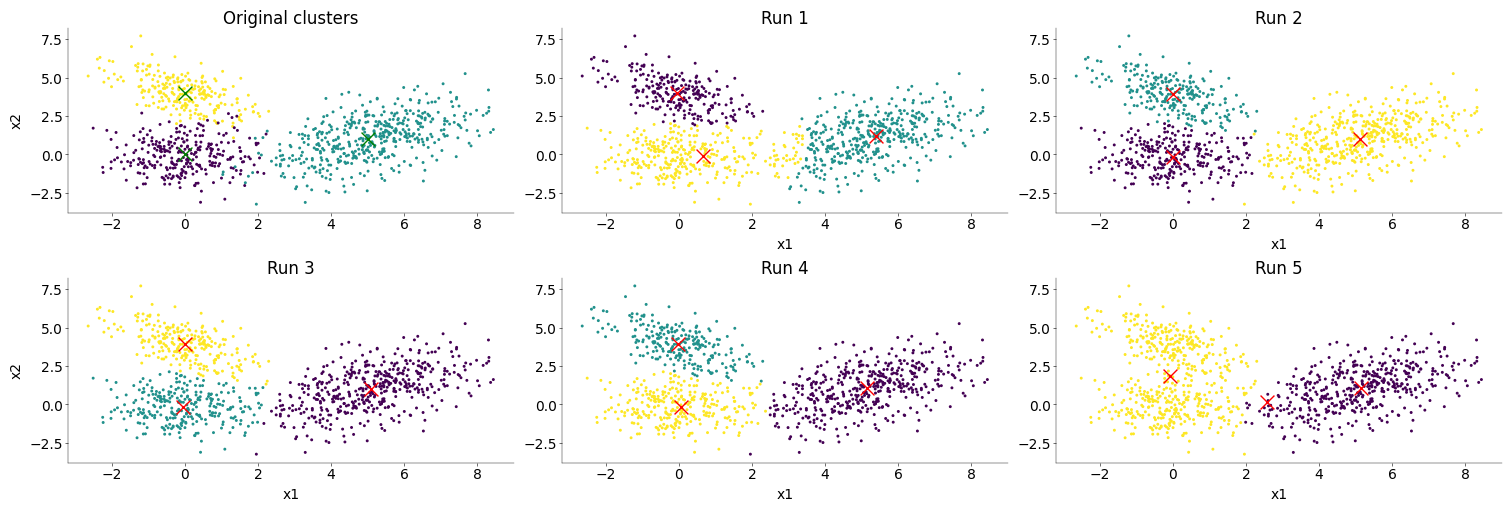

In [12]:
# -------------------------------------------------------------------------
# Run the algorithm 5 times on the toy data, plot and compare original and
# assigned clusters and answer the questions (1+1 pts)
# -------------------------------------------------------------------------


fig, axs = plt.subplots(2, 3, figsize=(15, 5), layout="constrained")
axs = axs.flatten()

axs[0].set_ylabel("x2")
axs[0].set_title("Original clusters")
axs[0].scatter(points[:, 0], points[:, 1], c=labels, s=5, cmap="viridis")
axs[0].scatter(m[:, 0], m[:, 1], c="green", s=100, marker="x")


for i in range(1, 6):
    # fit the model
    mog_labels, mog_m, mog_S, mog_p = fit_mog(points, 3, n_iters=30, random_seed=i)
    # plot the points and the clusters
    axs[i].scatter(points[:, 0], points[:, 1], c=mog_labels, s=5, cmap="viridis")
    axs[i].scatter(mog_m[:, 0], mog_m[:, 1], c="red", s=100, marker="x")
    axs[i].set_title(f"Run {i}")
    axs[i].set_xlabel("x1")

axs[3].set_ylabel("x2")

Text(0, 0.5, 'x2')

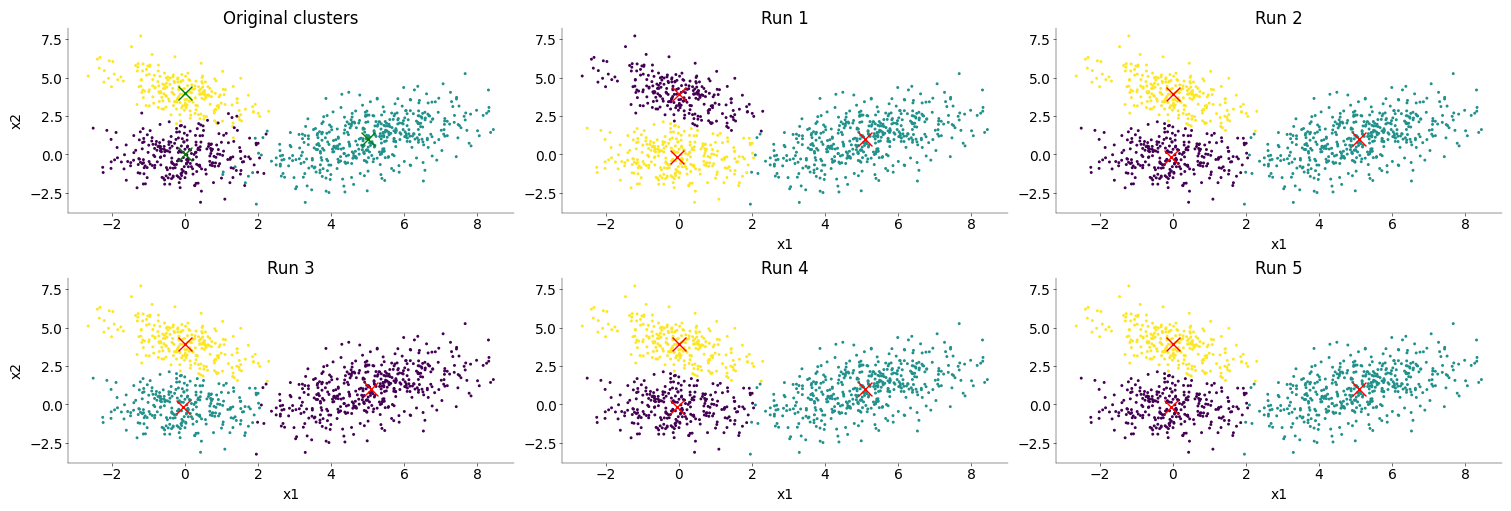

In [13]:
# -------------------------------------------------------------------------
# Here are some test runs based on kmeans initiliation for comparison
# -------------------------------------------------------------------------


fig, axs = plt.subplots(2, 3, figsize=(15, 5), layout="constrained")
axs = axs.flatten()

axs[0].set_ylabel("x2")
axs[0].set_title("Original clusters")
axs[0].scatter(points[:, 0], points[:, 1], c=labels, s=5, cmap="viridis")
axs[0].scatter(m[:, 0], m[:, 1], c="green", s=100, marker="x")


for i in range(1, 6):
    # fit the model
    mog_labels, mog_m, mog_S, mog_p = fit_mog(
        points, 3, n_iters=20, random_seed=i, init="kmeans"
    )
    # plot the points and the clusters
    axs[i].scatter(points[:, 0], points[:, 1], c=mog_labels, s=5, cmap="viridis")
    axs[i].scatter(mog_m[:, 0], mog_m[:, 1], c="red", s=100, marker="x")
    axs[i].set_title(f"Run {i}")
    axs[i].set_xlabel("x1")

axs[3].set_ylabel("x2")

### Questions

1) Do all runs converge to good solutions? If not, which one would you pick (only visual inspection required) as the best one?

Within 5 iterations, the randomly initialized GMM was could not converge to a sufficient cluster assignment especially for the data points of cluster 1 and 2. On the hand, the k-means initialized GMM was able to correctly assign almost every data point to the correct cluster. This is due to the fact that the k-means based initialization already assigns the cluster centers and prior probabilities based on distances of data points to the cluster centers. This way, it also avoids that the GMM algorithm gets stuck in poor local minima.

2) Do you get the same colors (=labels) in your best assignment(s) compared to the groundtruth? Does it have to be that way or not? Why?

When synthesizing the ground truth data, some points were randomly chosen to be very far from the original cluster centers. By nature, the GMM assigned these data points to the cluster whose center was closest and not according to the original labelling. Except for the these outliers, the remaining assignments were the same.

In [10]:
# YOUR CODE HERE

## Task 3: Model complexity
A priori we do not know how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 5 pts*



### Question (0.5 pts)

1) What is the number of parameters of the model?

$P = N_\text{clusters}*N_\text{dim}+N_\text{clusters}*\frac{N_\text{dim}*(N_\text{dim}+1)}{2}+N_\text{clusters}-1$

In [20]:
def mog_bic(
    x: np.ndarray, m: np.ndarray, S: np.ndarray, p: np.ndarray
) -> tuple[float, float]:
    """Compute the BIC for a fitted Mixture of Gaussian model

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    m: np.array, (n_clusters, n_dims)
        Means

    S: np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.array, (n_clusters, )
        Cluster weights / probablities

    Return
    ------

    bic: float
        BIC

    LL: float
        Log Likelihood
    """

    # -------------------------
    # implement the BIC (1.5 pts)
    # -------------------------

    n_samples, n_dims = x.shape
    n_clusters = m.shape[0]

    from scipy.stats import multivariate_normal
    from scipy.special import logsumexp

    log_probs = np.empty((n_samples, n_clusters))
    for j in range(n_clusters):
        # log weight + log N(x | m[j], S[j]) for all samples
        log_probs[:, j] = np.log(p[j]) + multivariate_normal.logpdf(
            x, mean=m[j], cov=S[j]
        )
    LL = float(np.sum(logsumexp(log_probs, axis=1)))

    # Number of parameters in the model
    n_params = (
        n_clusters * n_dims  # params for means
        + n_clusters * (n_dims * (n_dims + 1)) // 2  # params for covs
        + n_clusters
        - 1  # params for weights, -1 because p is normalized
    )

    bic = -2 * LL + n_params * np.log(n_samples)
    return bic, LL

In [21]:
# ----------------------------------------------------------------------------------------------------------------------
# Compute and plot the BIC for mixture models with different numbers of clusters (e.g., 2 - 6). (0.5 pts)
# Make your _estimate of the BIC_ robust against local minima, regardless of the initialization strategy used (0.5 pts)
# ----------------------------------------------------------------------------------------------------------------------

K = np.arange(2, 7)
num_seeds = 10

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

# run mog and BIC multiple times here
robust_BIC = np.zeros(len(K))
for i, k in enumerate(K):
    for j in range(num_seeds):
        mog_labels, mog_m, mog_S, mog_p = fit_mog(
            points, k, n_iters=30, random_seed=j, init="random"
        )
        BIC[j, i], LL[j, i] = mog_bic(points, mog_m, mog_S, mog_p)
    robust_BIC[i] = BIC[:, i].min()

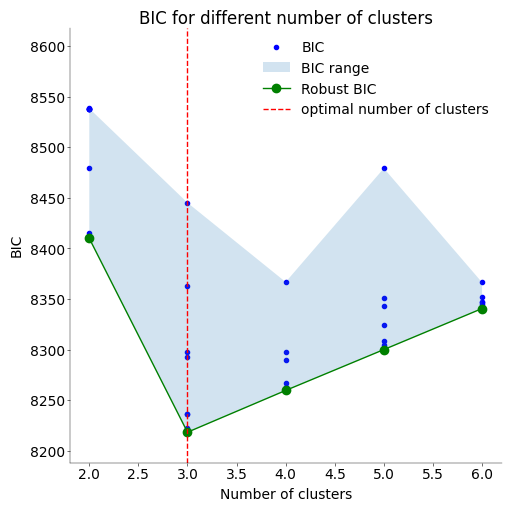

In [22]:
# ------------------------------------------------------------------------------------------
# Plot the result and answer the questions (1+1 pts)
# Don't forget to plot your robust estimate and highlight the estimated number of clusters!
# ------------------------------------------------------------------------------------------


fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")

## scatter all BIC values
for i in range(num_seeds):
    ax.scatter(K, BIC[i], color="blue")

# dummy for adding to the legend
ax.scatter([], [], color="blue", label="BIC")

ax.fill_between(
    K,
    BIC.min(axis=0),
    BIC.max(axis=0),
    alpha=0.2,
    label="BIC range",
)
ax.plot(K, robust_BIC, "o-", label="Robust BIC", color="green")

ax.axvline(
    x=robust_BIC.argmin() + 2,
    color="red",
    linestyle="--",
    label="optimal number of clusters",
)
ax.set_xlabel("Number of clusters")
ax.set_ylabel("BIC")
ax.set_title("BIC for different number of clusters")
ax.set_ylim(BIC.min() - 30, BIC.max() + 80)
ax.legend()

### Questions

1) What happens to the BIC if the model got stuck in a local minimum? For your reasoning, you can also refer to Task 2.

When the algorithm gets stuck in a local minimum the log loss stops decreasing and with it the BIC. This means that our resulting BIC will not be the lowest possible for the chosen number of clusters. 

2) The goal is to estimate which number of clusters best fits the data using the BIC. Therefore, what qualifies as a robust estimate? Explain your reasoning!
   
_(Hint: think about which number of cluster you would use and why)_

As expected for our toy data wich was generated from three Gaussians, we get a BIC curve that indicates that thress clusters are optimal. But we see that for random initialization, we should do several runs and pick the best possible BIC achieved (because results are more varied than for kmeans initialization and we get stuck in bad local minima more often).  Otherwise we might choose a random seed where the BIC we want to choose (for n_clusters=3) is worse than another number of clusters because it got stuck in a worse local optimum. Chossing the best of several runs is a robust optimum, because we essentially choose the best optimum we could find in the loss landscape. Runs where we are "unlucky" and get a very high BIC do not influence the result (as opposed to choosing the mean BIC). The more initializations we try per number of clusters, the more robust our estimate gets.

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (MoG fitting + model complexity selection).

Show the plot of the BIC as a function of the number of mixture components on the real data, highlight the robust estimate and based on that the best number of clusters.

For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot.

*Grading: 3 pts*


In [34]:
# -------------------------------------------------------------
# Run the algorithm on the set of extracted features (0.5 pts)
# -------------------------------------------------------------

K = np.arange(2, 16)
num_seeds = 5

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

# run mog and BIC multiple times here
robust_BIC = np.zeros(len(K))
for i, k in enumerate(K):
    for j in range(num_seeds):
        mog_labels, mog_m, mog_S, mog_p = fit_mog(
            b, k, n_iters=20, random_seed=j, init="kmeans"
        )
        BIC[j, i], LL[j, i] = mog_bic(b, mog_m, mog_S, mog_p)
    robust_BIC[i] = BIC[:, i].min()
    print(f"robust BIC for {k} clusters: {robust_BIC[i]}")

robust BIC for 2 clusters: 2770123.0141990604
robust BIC for 3 clusters: 2747779.625988477
robust BIC for 4 clusters: 2737546.188315651
robust BIC for 5 clusters: 2734358.7706141686
robust BIC for 6 clusters: 2731867.94362652
robust BIC for 7 clusters: 2728447.1978121316
robust BIC for 8 clusters: 2728871.487380349
robust BIC for 9 clusters: 2726968.6652227137
robust BIC for 10 clusters: 2727456.7194625027
robust BIC for 11 clusters: 2728072.3622685326
robust BIC for 12 clusters: 2726058.8838048796
robust BIC for 13 clusters: 2725794.222166432
robust BIC for 14 clusters: 2725658.482866792
robust BIC for 15 clusters: 2726106.304162667


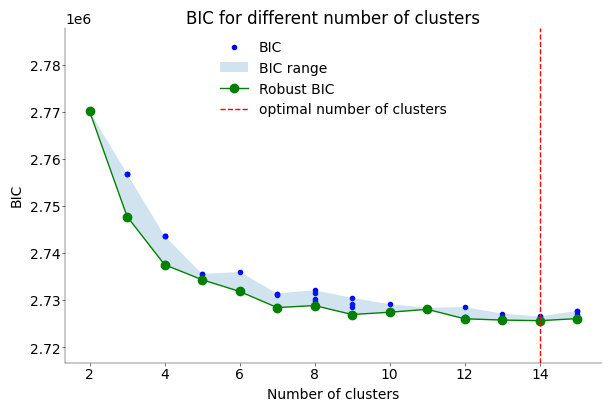

In [35]:
# ----------------------------------------------------------------------------------------------------------------------
# Plot the BIC over number of mixture components and highlight robust estimate and optimal number of clusters (0.5 pts)
# ----------------------------------------------------------------------------------------------------------------------


def plot_bic(BIC, K, num_seeds, robust_BIC):
    fig, ax = plt.subplots(figsize=(6, 4))
    ## scatter all BIC values
    for i in range(num_seeds):
        ax.scatter(K, BIC[i], color="blue")

    # dummy for adding to the legend
    ax.scatter([], [], color="blue", label="BIC")

    ax.fill_between(
        K,
        BIC.min(axis=0),
        BIC.max(axis=0),
        alpha=0.2,
        label="BIC range",
    )
    ax.plot(K, robust_BIC, "o-", label="Robust BIC", color="green")
    ax.axvline(
        x=robust_BIC.argmin() + 2,
        color="red",
        linestyle="--",
        label="optimal number of clusters",
    )
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("BIC")
    ax.set_title("BIC for different number of clusters")
    ax.set_ylim(
        BIC.min() - 0.2 * (BIC.max() - BIC.min()),
        BIC.max() + 0.4 * (BIC.max() - BIC.min()),
    )
    ax.legend()
    plt.show()


plot_bic(BIC, K, num_seeds, robust_BIC)

robust BIC for 2 clusters: 2762104.4388337675
robust BIC for 3 clusters: 2744454.4029810396
robust BIC for 4 clusters: 2739131.240524133
robust BIC for 5 clusters: 2734424.911457369
robust BIC for 6 clusters: 2732206.0823928295
robust BIC for 7 clusters: 2729173.452981157
robust BIC for 8 clusters: 2727980.3761902493
robust BIC for 9 clusters: 2728415.586887208
robust BIC for 10 clusters: 2727907.4545374718
robust BIC for 11 clusters: 2728502.3455733093
robust BIC for 12 clusters: 2727566.9397371802
robust BIC for 13 clusters: 2728078.742920036
robust BIC for 14 clusters: 2726937.0369629525
robust BIC for 15 clusters: 2729878.666693547


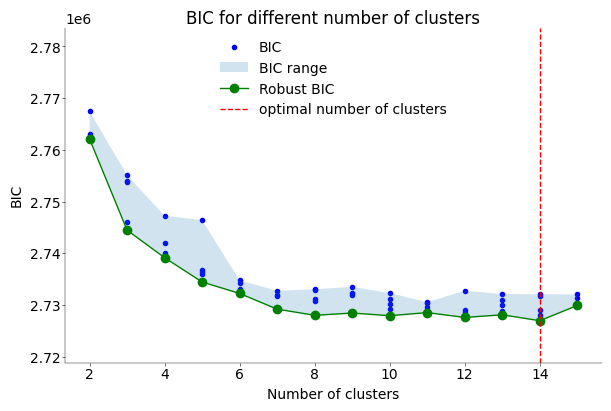

In [36]:
# ---------------------------------------------------------------
# For comparison: this is what it looks like with the less robust random initialization
# ---------------------------------------------------------------
K = np.arange(2, 16)
num_seeds = 5

BIC_randominit = np.zeros((num_seeds, len(K)))
LL_randominit = np.zeros((num_seeds, len(K)))

# run mog and BIC multiple times here
robust_BIC_randominit = np.zeros(len(K))
for i, k in enumerate(K):
    for j in range(num_seeds):
        mog_labels, mog_m, mog_S, mog_p = fit_mog(
            b, k, n_iters=20, random_seed=j, init="random"
        )
        BIC_randominit[j, i], LL_randominit[j, i] = mog_bic(b, mog_m, mog_S, mog_p)
    robust_BIC_randominit[i] = BIC_randominit[:, i].min()
    print(f"robust BIC for {k} clusters: {robust_BIC_randominit[i]}")

plot_bic(BIC_randominit, K, num_seeds, robust_BIC_randominit)

Refit model with lowest BIC and plot data points

In [37]:
random_seed, kk = np.where(BIC == BIC.min())
random_seed = random_seed[0]
kk = kk[0]
print(f"lowest BIC: # cluster = {K[kk]}")
a, m, S, p = fit_mog(b, K[kk], random_seed=random_seed, init="kmeans")

lowest BIC: # cluster = 14


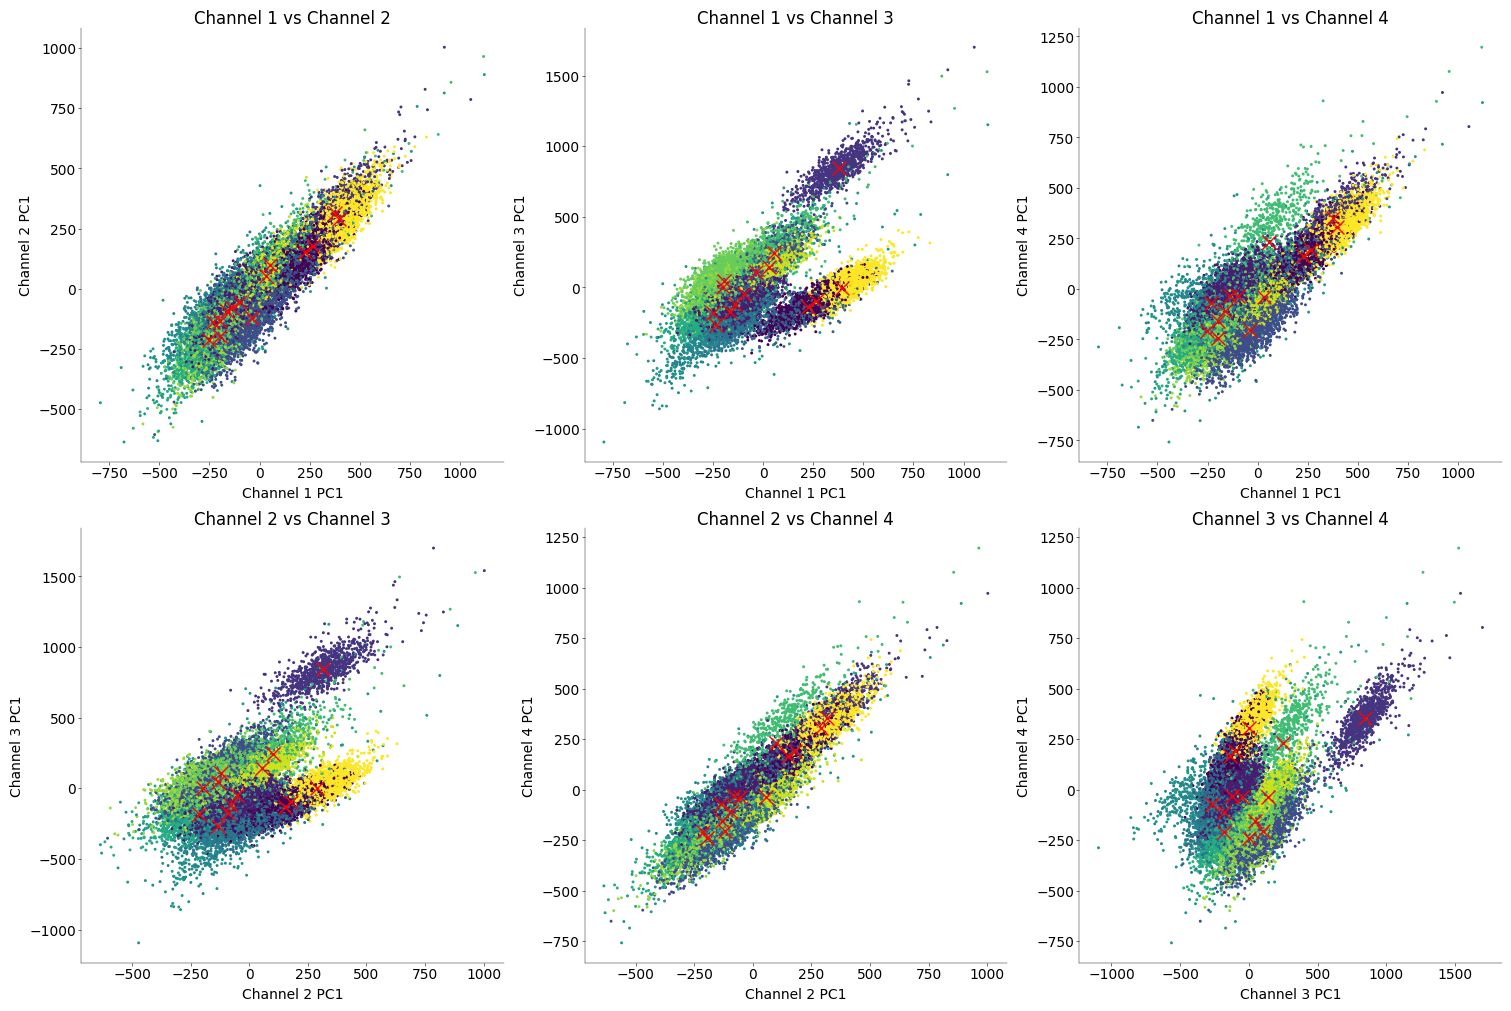

In [38]:
# ------------------------------------------------------------------------------------------------------------------
# Create scatterplots of the first PCs under the best model for all pairwise combinations of the 4 channels. (1 pt)
# ------------------------------------------------------------------------------------------------------------------

fig, ax = plt.subplots(2, 3, figsize=(15, 10), layout="constrained")
ax = ax.flatten()

channels = [0, 1, 2, 3]
channel_idx = [0, 3, 6, 9]

pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

for idx, (ch1, ch2) in enumerate(pairs):
    ax[idx].scatter(
        b[:, channel_idx[ch1]], b[:, channel_idx[ch2]], c=a, s=5, cmap="viridis"
    )
    ax[idx].scatter(
        m[:, channel_idx[ch1]], m[:, channel_idx[ch2]], c="red", s=100, marker="x"
    )
    ax[idx].set_xlabel(f"Channel {ch1 + 1} PC1")
    ax[idx].set_ylabel(f"Channel {ch2 + 1} PC1")
    ax[idx].set_title(f"Channel {ch1 + 1} vs Channel {ch2 + 1}")

plt.show()

## Task 5: Cluster separation and Correlograms

As postprocessing, implement the calculation of auto- and cross correlograms over the spike times.

Plot the (auto-/cross-) correlograms, displaying a time frame of -30ms to +30ms. Choose a good bin size and interprete the resulting diagrams.

_Grading: 3 pts_

#### Hints

_It is faster to calculate the histogram only over the spiketimes that are in the displayed range. Filter the spike times before calculating the histogram!_

_For the autocorrelogram, make sure not to include the time difference between a spike and itself (which would be exactly 0)_

_For the correlogram an efficient implementation is very important - looping over all spike times is not feasible. Instead, make use of numpy vectorization and broadcasting - you can use functions such as tile or repeat._

In [39]:
# ----------------------------------------------------------------------
# Implement a function for calculating the spike time differences (1pt)
# ----------------------------------------------------------------------
def cross_time_diff(spiketimes1: np.ndarray, spiketimes2: np.ndarray) -> np.ndarray:
    """Compute the pairwise time differences between two sets of spike times.

    Parameters
    ----------
    spiketimes1: np.ndarray, (n_spikes1, )
        Spike times of the first cluster
    spiketimes2: np.ndarray, (n_spikes2, )
        Spike times of the second cluster

    Return
    ------

    time_diff: np.ndarray, (n_spikes1, n_spikes2)
        Pairwise time differences between the two sets of spike times
        (i.e., spiketimes1[i] - spiketimes2[j])
    """
    return spiketimes1[:, None] - spiketimes2[None, :]

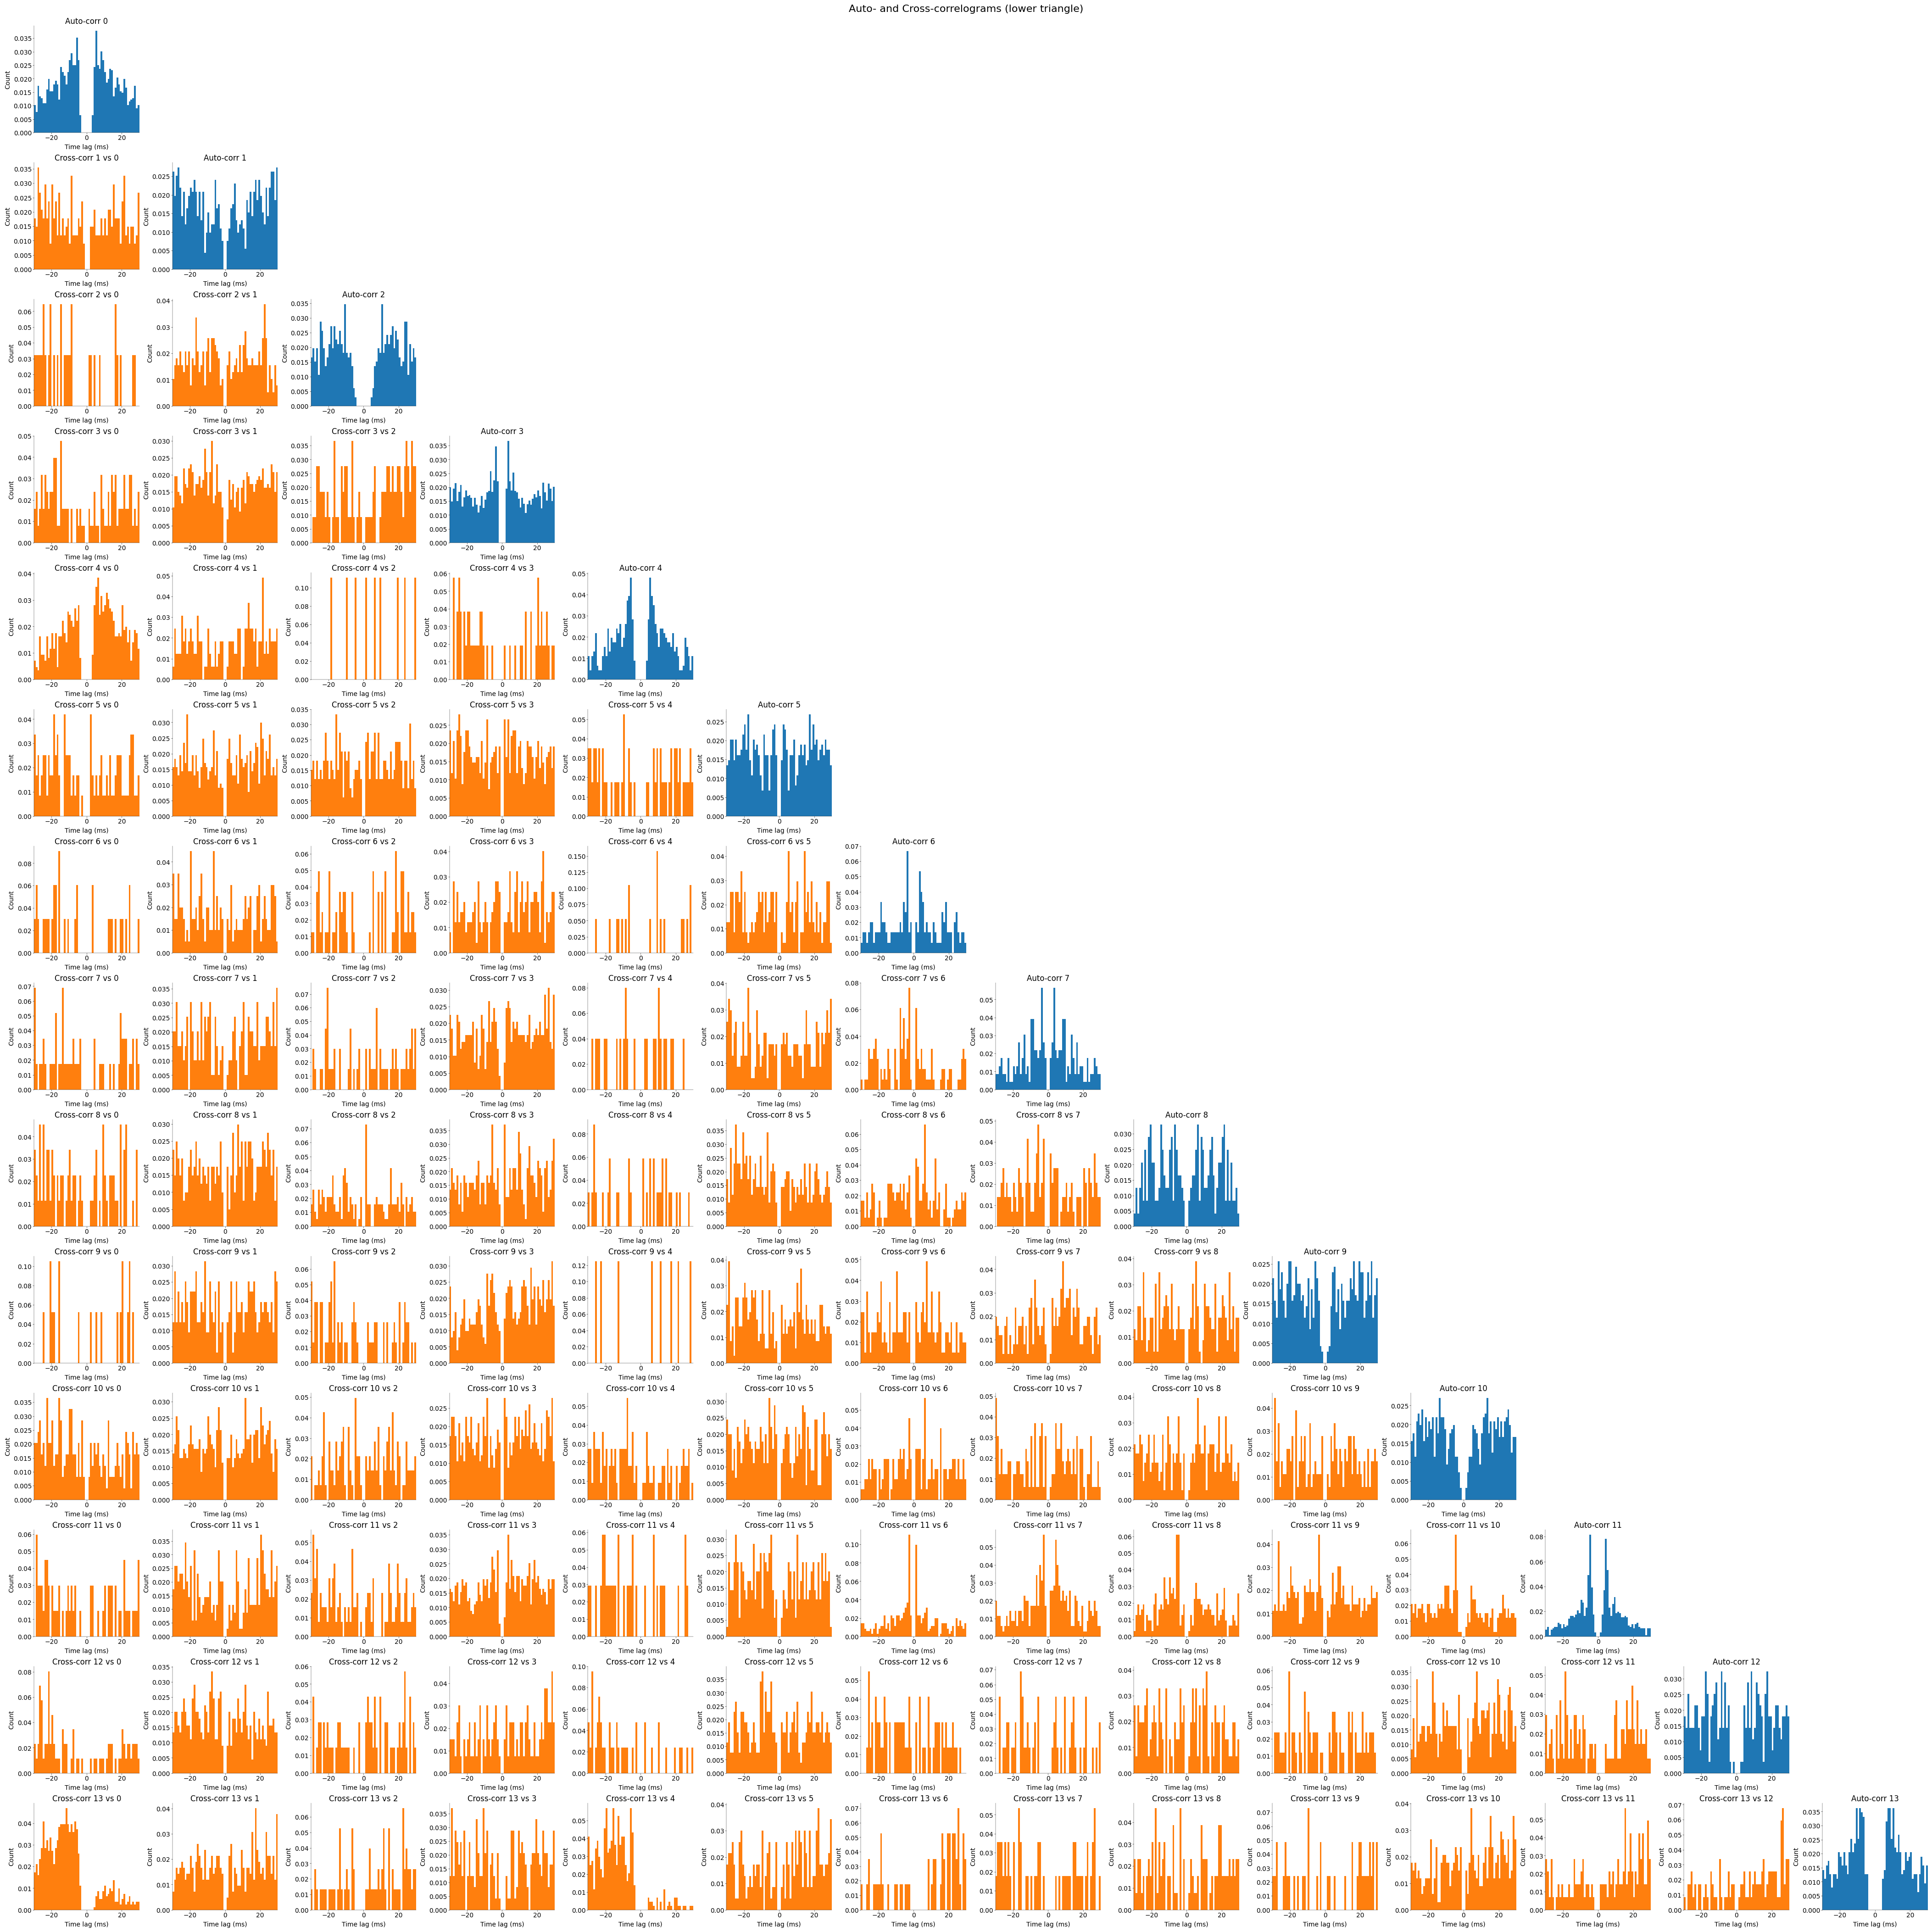

In [43]:
# -----------------------------------------------------------------------------------
# Calculate and plot auto- and cross correlograms and answer the questions (1+1 pts)
# -----------------------------------------------------------------------------------
clusters = np.unique(a)
K = len(clusters)

# Histogram parameters
bin_width = 1.0  # ms
bins = np.arange(-30, 30 + bin_width, bin_width)

fig, axes = plt.subplots(K, K, figsize=(3 * K, 3 * K), constrained_layout=True)

for i, k1 in enumerate(clusters):
    spk1 = t[a == k1]
    for j, k2 in enumerate(clusters):
        ax = axes[i, j]

        if i < j:
            ax.axis("off")
            continue

        if i == j:
            diffs = cross_time_diff(spk1, spk1).flatten()
            diffs = diffs[np.abs(diffs) > 1e-6]
            ax.hist(diffs, bins=bins, density=True, color="C0") # plot in probability density to compare easilty 
            ax.set_title(f"Auto-corr {k1}")
        else:
            spk2 = t[a == k2]
            diffs = cross_time_diff(spk1, spk2).flatten()
            diffs = diffs[(diffs >= -30) & (diffs <= 30)]
            ax.hist(diffs, bins=bins, density=True, color="C1") # plot in probability density to compare easilty
            ax.set_title(f"Cross-corr {k1} vs {k2}")

        ax.set_xlim(-30, 30)
        ax.set_xlabel("Time lag (ms)")
        ax.set_ylabel("Count")

plt.suptitle("Auto- and Cross-correlograms (lower triangle)", fontsize=16)
plt.show()

### Questions
1) Based on the plot, do you see clusters that contain spikes likely from a single neuron?

The clusters 0 and 2 are showing a clean refractory period (see answer to question 4). Therefore, they are likely to contain spikes from only a single neuron.

2) Do you see cases where plural clusters might come from the same neuron?

No, for this we would expect to see a refractory period resembling pattern on any of the cross-correlograms on the off-diagonal. This is no clear such case here.

3) Do you see clusters that might contain spikes from plural neurons?

The autocorrelograms 1, 2 and 4 are not really showing a refractory period (see answer to question 4), which indicates that they might contain spikes from multiple neurons.

4) Explain the term "refractory period" and how one can see it in this plot.

During the refractory period of a neuron, no spike is emitted - even when the neuron gets inputs that are strong enough to theoretically cause a spike (this is especially important for what is called the absolute refractory period). In this plot, refactory periods are visible as gaps in the correlograms around the 0 point on the x-axis. We expect a cluster that contains spikes from only a single neuron to have a clearly visible refractory period. If this gap is missing, that is an indicator that spikes from more than one neuron might be in the cluster. If an off-diagonal cluster shows a refractory period resembling pattern that might indicate that we might have sorted spikes from the same neuron into several clusters.

## Bonus Task (Optional): Mixture of drifting t-distributions

Instead of a simple Gaussian Mixture Model, more advanced algorithms can be implemented.
Implement a basic version of the mixture of drifting t-distributions (follow https://github.com/aecker/moksm/blob/master/MoT_Kalman.pdf).
What is the advantage of that method?

_Grading: 2 BONUS Points._


_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

In [57]:
# create a basic t-shiftiing distribution
def fit_mot_kalman(
    x: np.ndarray,
    spiketimes: np.ndarray,
    n_clusters: int,
    n_iters: int = 10,
    df: float = 4.0,
    Q: float = 1e-3,
    random_seed: int = 0,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Fit a mixture of drifting multivariate t‑distributions using a Kalman‐like update.
    Parameters
    ----------
    x           : (N, D) data
    spiketimes  : (N,) time stamps for drift modeling
    n_clusters  : number of mixture components
    n_iters     : EM iterations
    df          : degrees of freedom for the t‑distribution
    Q           : process noise covariance (drift strength)
    random_seed : RNG seed, ensures reproducibility
    Returns
    -------
    labels : (N,) hard assignments
    m      : (K, D) estimated means
    S      : (K, D, D) estimated covariances
    p      : (K,) mixing proportions
    """
    rng = np.random.default_rng(random_seed)
    N, D = x.shape
    t = spiketimes - spiketimes.min()
    # init via KMeans
    km = KMeans(n_clusters=n_clusters, random_state=random_seed).fit(x)
    labels = km.labels_
    m = km.cluster_centers_.copy()
    S = np.array(
        [np.cov(x[labels == k].T) + 1e-6 * np.eye(D) for k in range(n_clusters)]
    )
    p = np.array([np.mean(labels == k) for k in range(n_clusters)])
    Qk = [Q * np.eye(D) for _ in range(n_clusters)]

    for it in range(n_iters):
        # E‑step: responsibilities under Student‑t (instead of gamma as in the paper)
        r = np.zeros((N, n_clusters))
        for k in range(n_clusters):
            diff = x - m[k]
            invS = np.linalg.inv(S[k])
            maha = np.sum(diff @ invS * diff, axis=1)
            const = gamma((df + D) / 2) / (
                gamma(df / 2) * (df * np.pi) ** (D / 2) * np.sqrt(np.linalg.det(S[k]))
            )
            r[:, k] = p[k] * const * (1 + maha / df) ** (-(df + D) / 2)
        r /= r.sum(axis=1, keepdims=True)

        # M‑step
        Nk = r.sum(axis=0)
        p = Nk / N

        # update means with simple drift term (Kalman like-but not as complex as in the paper)
        for k in range(n_clusters):
            wk = r[:, k]
            # weighted least squares of x on time t to estimate drift slope & intercept
            A = np.vstack([np.ones(N), t]).T
            W = np.diag(wk)
            coeffs = np.linalg.inv(A.T @ W @ A) @ (A.T @ (W @ x))
            # intercept is coeffs[0,:], slope is coeffs[1,:]
            m[k] = coeffs[0] + coeffs[1] * t.mean()
            # covariance update + process noise
            diff = x - m[k]
            S[k] = (wk[:, None] * diff).T @ diff / Nk[k] + Qk[k]

    labels = r.argmax(axis=1)
    return labels, m, S, p

In [46]:
def generate_drifting_toy(
    N: int = 1000,
    D: int = 2,
    K: int = 3,
    Tmax: float = 100.0,
    random_seed: int = 0,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Simulate N points in D dims from K clusters whose means drift linearly in time.
    Returns (x, t, labels).
    """
    rng = np.random.default_rng(random_seed)
    # mixing proportions
    p = np.array([0.3, 0.5, 0.2])
    # static intercepts and per‐cluster drift slopes
    intercepts = np.array([[0.0, 0.0], [5.0, 1.0], [0.0, 4.0]])
    slopes = np.array([[0.05, -0.02], [0.0, 0.03], [-0.04, 0.01]])
    # constant covariance for noise
    covs = np.array([0.5 * np.eye(D) for _ in range(K)])
    # sample labels and times
    labels = rng.choice(K, size=N, p=p)
    t = rng.uniform(0.0, Tmax, size=N)
    # sample features
    x = np.zeros((N, D))
    for k in range(K):
        idx = labels == k
        tk = t[idx][:, None]
        mu_t = intercepts[k] + slopes[k] * tk
        x[idx] = rng.multivariate_normal(np.zeros(D), covs[k], size=idx.sum()) + mu_t
    return x, t, labels

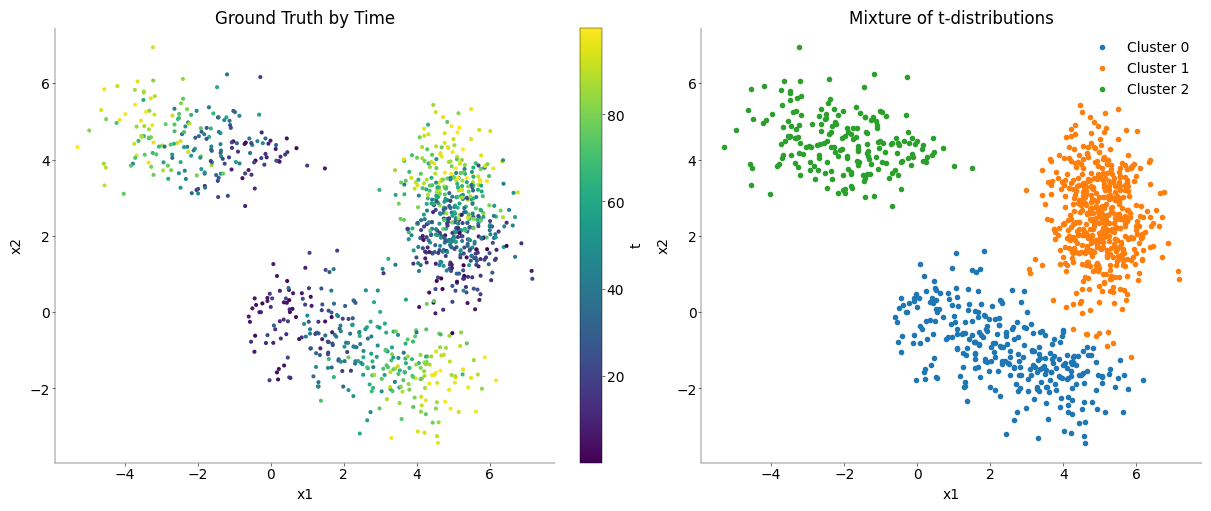

In [59]:
# create toy data
x, t_toy, ground_labels = generate_drifting_toy(
    N=1000, D=2, K=3, Tmax=100, random_seed=42
)

# test the fit_mot_kalman function
mot_labels, m_mot, S_mot, p_mot = fit_mot_kalman(
    x, t_toy, n_clusters=3, n_iters=10, df=4.0, Q=1e-3, random_seed=42
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Left: points colored by time, with a colorbar
sc_time = axes[0].scatter(x[:, 0], x[:, 1], c=t_toy, cmap="viridis", s=15)
axes[0].set_title("Ground Truth by Time")
cbar = fig.colorbar(sc_time, ax=axes[0])
cbar.set_label("t")

# Right: points colored by predicted cluster, with a legend
scatter_clusters = []
[axes[1].scatter(x[mot_labels == i, 0], x[mot_labels == i, 1]) for i in range(3)]

axes[1].set_title("Mixture of t-distributions")

[axes[i].set_xlabel("x1") for i in range(2)]
[axes[i].set_ylabel("x2") for i in range(2)]
axes[1].legend([f"Cluster {i}" for i in range(3)])

plt.show()

In [60]:
# Run the BIC using real data by mixture of drifting t-distribution

K = np.arange(2, 16)
num_seeds = 5

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

# run mog and BIC multiple times here
robust_BIC = np.zeros(len(K))
for i, k in enumerate(K):
    for j in range(num_seeds):
        mog_labels, mog_m, mog_S, mog_p = fit_mot_kalman(
            b, t, k, n_iters=5, random_seed=j
        )
        BIC[j, i], LL[j, i] = mog_bic(b, mog_m, mog_S, mog_p)
    robust_BIC[i] = BIC[:, i].min()
    print(f"robust BIC for {k} clusters: {robust_BIC[i]}")

plot_bic(BIC, K, num_seeds, robust_BIC)

robust BIC for 2 clusters: 2770186.99260665
robust BIC for 3 clusters: 2748276.078561199
robust BIC for 4 clusters: 2744400.2469146685
robust BIC for 5 clusters: 2739559.4712432497
robust BIC for 6 clusters: 2737128.5344778053
robust BIC for 7 clusters: 2737125.345000186


KeyboardInterrupt: 

In [ ]:
random_seed, kk = np.where(BIC == BIC.min())
random_seed = random_seed[0]
kk = kk[0]
print(f"lowest BIC: # cluster = {K[kk]}")
a, m, S, p = fit_mot_kalman(b, t, K[kk], n_iters=5, random_seed=random_seed)

# Create scatterplots of the first PCs under the best model for all pairwise combinations of the 4 channels.

fig, ax = plt.subplots(2, 3, figsize=(15, 10), layout="constrained")
ax = ax.flatten()

channels = [0, 1, 2, 3]
channel_idx = [0, 3, 6, 9]

pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

for idx, (ch1, ch2) in enumerate(pairs):
    ax[idx].scatter(
        b[:, channel_idx[ch1]], b[:, channel_idx[ch2]], c=a, s=5, cmap="viridis"
    )
    ax[idx].scatter(
        m[:, channel_idx[ch1]], m[:, channel_idx[ch2]], c="red", s=100, marker="x"
    )
    ax[idx].set_xlabel(f"Channel {ch1 + 1} PC1")
    ax[idx].set_ylabel(f"Channel {ch2 + 1} PC1")
    ax[idx].set_title(f"Channel {ch1 + 1} vs Channel {ch2 + 1}")

plt.show()

In [ ]:
# Calculate and plot auto- and cross correlograms

clusters = np.unique(a)
K = len(clusters)

# Histogram parameters
bin_width = 1.0  # ms
bins = np.arange(-30, 30 + bin_width, bin_width)

fig, axes = plt.subplots(K, K, figsize=(3 * K, 3 * K), constrained_layout=True)

for i, k1 in enumerate(clusters):
    spk1 = t[a == k1]
    for j, k2 in enumerate(clusters):
        ax = axes[i, j]

        if i < j:
            ax.axis("off")
            continue

        if i == j:
            diffs = cross_time_diff(spk1, spk1).flatten()
            diffs = diffs[np.abs(diffs) > 1e-6]
            ax.hist(diffs, bins=bins, density=True, color="C0") # plot in probability density to compare easilty 
            ax.set_title(f"Auto-corr {k1}")
        else:
            spk2 = t[a == k2]
            diffs = cross_time_diff(spk1, spk2).flatten()
            diffs = diffs[(diffs >= -30) & (diffs <= 30)]
            ax.hist(diffs, bins=bins, density=True, color="C1") # plot in probability density to compare easilty
            ax.set_title(f"Cross-corr {k1} vs {k2}")

        ax.set_xlim(-30, 30)
        ax.set_xlabel("Time lag (ms)")
        ax.set_ylabel("Count")

plt.suptitle("Auto- and Cross-correlogram", fontsize=16)
plt.show()

## Advantage over classical GMM
By design, the mixture of drifting t-distributions consideres the temporal drift of the data points using a Kalman filter. This allows to track the cluster centers over time and adapt to changes in the data distribution. This is especially useful for electrophysiological recordings, where noise like electrode drift can decrease data quality and might lead to misclassification of data points. Additionally, the t-distribution is more robust to outliers due to its heavier tails and fits non-Gaussian noise better. Compared to the original and complex algorithm of the paper, we simplified the mixture model by using a reduced Kalman filter, less complex t-distribution and less latent variables.